In [3]:
from typing_extensions import Annotated

import autogen

config_list = autogen.config_list_from_json(env_or_file="OAI_CONFIG_LIST.json")
llm_config = {"config_list": config_list}

## Scenario 1
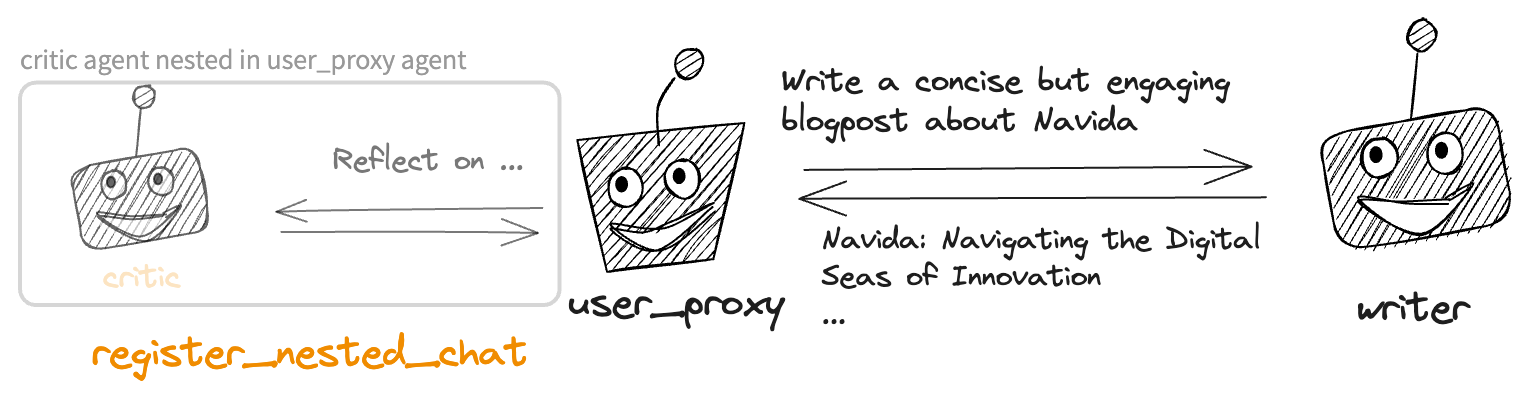

In [6]:
task = """Write a concise but engaging blogpost about Navida."""

In [7]:
writer = autogen.AssistantAgent(
    name="Writer",
    llm_config={"config_list": config_list},
    system_message="""
    You are a professional writer, known for your insightful and engaging articles.
    You transform complex concepts into compelling narratives.
    You should improve the quality of the content based on the feedback from the user.
    """,
)

user_proxy = autogen.UserProxyAgent(
    name="User",
    human_input_mode="NEVER",
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "tasks",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

critic = autogen.AssistantAgent(
    name="Critic",
    llm_config={"config_list": config_list},
    system_message="""
    You are a critic, known for your thoroughness and commitment to standards.
    Your task is to scrutinize content for any harmful elements or regulatory violations, ensuring
    all materials align with required guidelines.
    For code
    """,
)

In [8]:
def reflection_message(recipient, messages, sender, config):
    print("Reflecting...", "yellow")
    return f"Reflect and provide critique on the following writing. \n\n {recipient.chat_messages_for_summary(sender)[-1]['content']}"


user_proxy.register_nested_chats(
    [{"recipient": critic, "message": reflection_message, "summary_method": "last_msg", "max_turns": 1}],
    trigger=writer,  # condition=my_condition,
)

res = user_proxy.initiate_chat(recipient=writer, message=task, max_turns=2, summary_method="last_msg")

User (to Writer):

Write a concise but engaging blogpost about Navida.

--------------------------------------------------------------------------------
Writer (to User):

### Discovering Navida: The Hidden Gem of Winter Wonderland

As winter blankets the landscape in a crisp layer of snow, many seekers of seasonal magic flock to popular ski resorts and bustling holiday markets. Yet, nestled quietly away from the crowds lies an enchanting destination: Navida. This charming locale offers a perfect blend of natural beauty, thrilling activities, and cozy experiences that beckon travelers looking for a more intimate winter getaway.

#### A Winter Wonderland

Navida is defined by its breathtaking scenery. Towering pines draped in glistening snow create a fairy-tale backdrop, while serene lakes freeze over, inviting visitors to partake in ice skating or simply indulge in the tranquility of nature. The air is crisp and refreshing, making every breath feel invigorating, as if winter itself is 

In [9]:
res = user_proxy.initiate_chat(recipient=writer, message=task, max_turns=1, summary_method="last_msg")

User (to Writer):

Write a concise but engaging blogpost about Navida.

--------------------------------------------------------------------------------
Writer (to User):

### Discovering Navida: The Hidden Gem of Winter Wonderland

As winter blankets the landscape in a crisp layer of snow, many seekers of seasonal magic flock to popular ski resorts and bustling holiday markets. Yet, nestled quietly away from the crowds lies an enchanting destination: Navida. This charming locale offers a perfect blend of natural beauty, thrilling activities, and cozy experiences that beckon travelers looking for a more intimate winter getaway.

#### A Winter Wonderland

Navida is defined by its breathtaking scenery. Towering pines draped in glistening snow create a fairy-tale backdrop, while serene lakes freeze over, inviting visitors to partake in ice skating or simply indulge in the tranquility of nature. The air is crisp and refreshing, making every breath feel invigorating, as if winter itself is 

## Scenario 2
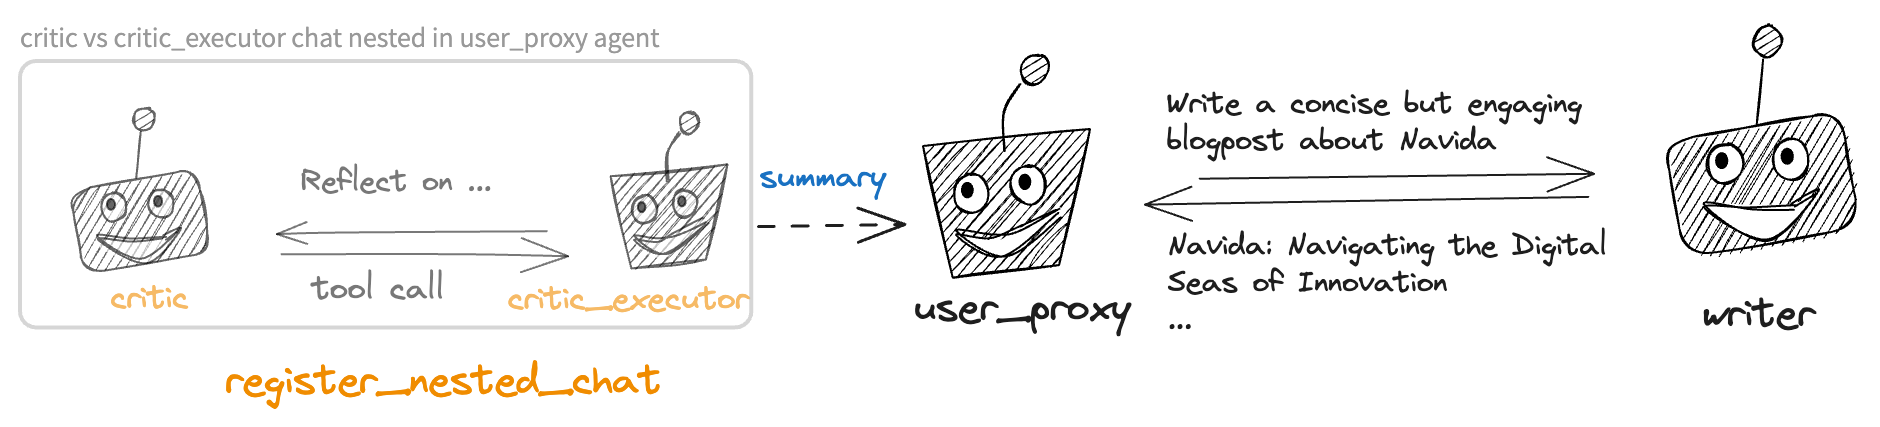

In [10]:
critic_executor = autogen.UserProxyAgent(
    name="Critic_Executor",
    human_input_mode="NEVER",
    # is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "tasks",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

@critic_executor.register_for_execution()
@critic.register_for_llm(name="check_harmful_content", description="Check if content contain harmful keywords.")
def check_harmful_content(content: Annotated[str, "Content to check if harmful keywords."]):
    # List of harmful keywords for demonstration purposes
    harmful_keywords = ["violence", "hate", "bullying", "death"]

    # Normalize the input text to lower case to ensure case-insensitive matching
    text = content.lower()

    print(f"Checking for harmful content...{text}", "yellow")
    # Check if any of the harmful keywords appear in the text
    for keyword in harmful_keywords:
        if keyword in text:
            return "Denied. Harmful content detected:" + keyword  # Harmful content detected

    return "Approve. TERMINATE"  # No harmful content detected

def reflection_message_no_harm(recipient, messages, sender, config):
    print("Reflecting...", "yellow")
    return f"Reflect and provide critique on the following writing. Ensure it does not contain harmful content. You can use tools to check it. \n\n {recipient.chat_messages_for_summary(sender)[-1]['content']}"

user_proxy.register_nested_chats(
    [
        {
            "sender": critic_executor,
            "recipient": critic,
            "message": reflection_message_no_harm,
            "max_turns": 2,
            "summary_method": "last_msg",
        }
    ],
    trigger=writer,  # condition=my_condition,
)


res = user_proxy.initiate_chat(recipient=writer, message=task, max_turns=2, summary_method="last_msg")

The return type of the function 'check_harmful_content' is not annotated. Although annotating it is optional, the function should return either a string, a subclass of 'pydantic.BaseModel'.


User (to Writer):

Write a concise but engaging blogpost about Navida.

--------------------------------------------------------------------------------
Writer (to User):

### Discovering Navida: The Hidden Gem of Winter Wonderland

As winter blankets the landscape in a crisp layer of snow, many seekers of seasonal magic flock to popular ski resorts and bustling holiday markets. Yet, nestled quietly away from the crowds lies an enchanting destination: Navida. This charming locale offers a perfect blend of natural beauty, thrilling activities, and cozy experiences that beckon travelers looking for a more intimate winter getaway.

#### A Winter Wonderland

Navida is defined by its breathtaking scenery. Towering pines draped in glistening snow create a fairy-tale backdrop, while serene lakes freeze over, inviting visitors to partake in ice skating or simply indulge in the tranquility of nature. The air is crisp and refreshing, making every breath feel invigorating, as if winter itself is 

# Solving Complex Tasks with A Sequence of Nested Chats

In [11]:
import autogen

config_list = autogen.config_list_from_json(env_or_file="OAI_CONFIG_LIST.json")
llm_config = {"config_list": config_list}

In [12]:
tasks = [
    """On which days in 2024 was Microsoft Stock higher than $400? Comment on the stock performance.""",
    """Make a pleasant joke about it.""",
]

In [13]:
inner_assistant = autogen.AssistantAgent(
    "Inner-assistant",
    llm_config=llm_config,
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
)

inner_code_interpreter = autogen.UserProxyAgent(
    "Inner-code-interpreter",
    human_input_mode="NEVER",
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,
    },
    default_auto_reply="",
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
)

groupchat = autogen.GroupChat(
    agents=[inner_assistant, inner_code_interpreter],
    messages=[],
    speaker_selection_method="round_robin",  # With two agents, this is equivalent to a 1:1 conversation.
    allow_repeat_speaker=False,
    max_round=8,
)

manager = autogen.GroupChatManager(
    groupchat=groupchat,
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    llm_config=llm_config,
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,
    },
)

In [14]:
assistant_1 = autogen.AssistantAgent(
    name="Assistant_1",
    llm_config={"config_list": config_list},
)

assistant_2 = autogen.AssistantAgent(
    name="Assistant_2",
    llm_config={"config_list": config_list},
)

writer = autogen.AssistantAgent(
    name="Writer",
    llm_config={"config_list": config_list},
    system_message="""
    You are a professional writer, known for
    your insightful and engaging articles.
    You transform complex concepts into compelling narratives.
    """,
)

reviewer = autogen.AssistantAgent(
    name="Reviewer",
    llm_config={"config_list": config_list},
    system_message="""
    You are a compliance reviewer, known for your thoroughness and commitment to standards.
    Your task is to scrutinize content for any harmful elements or regulatory violations, ensuring
    all materials align with required guidelines.
    You must review carefully, identify potential issues, and maintain the integrity of the organization.
    Your role demands fairness, a deep understanding of regulations, and a focus on protecting against
    harm while upholding a culture of responsibility.
    """,
)

user = autogen.UserProxyAgent(
    name="User",
    human_input_mode="NEVER",
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "tasks",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

In [15]:
def writing_message(recipient, messages, sender, config):
    return f"Polish the content to make an engaging and nicely formatted blog post. \n\n {recipient.chat_messages_for_summary(sender)[-1]['content']}"


nested_chat_queue = [
    {"recipient": manager, "summary_method": "reflection_with_llm"},
    {"recipient": writer, "message": writing_message, "summary_method": "last_msg", "max_turns": 1},
    {"recipient": reviewer, "message": "Review the content provided.", "summary_method": "last_msg", "max_turns": 1},
    {"recipient": writer, "message": writing_message, "summary_method": "last_msg", "max_turns": 1},
]
assistant_1.register_nested_chats(
    nested_chat_queue,
    trigger=user,
)
# user.initiate_chat(assistant, message=tasks[0], max_turns=1)

res = user.initiate_chats(
    [
        {"recipient": assistant_1, "message": tasks[0], "max_turns": 1, "summary_method": "last_msg"},
        {"recipient": assistant_2, "message": tasks[1]},
    ]
)


********************************************************************************
Starting a new chat....

********************************************************************************
User (to Assistant_1):

On which days in 2024 was Microsoft Stock higher than $400? Comment on the stock performance.

--------------------------------------------------------------------------------

********************************************************************************
Starting a new chat....

********************************************************************************
Assistant_1 (to chat_manager):

On which days in 2024 was Microsoft Stock higher than $400? Comment on the stock performance.

--------------------------------------------------------------------------------

Next speaker: Inner-assistant



/home/autogen/.local/lib/python3.11/site-packages/autogen/agentchat/chat.py:47: UserWarning: Repetitive recipients detected: The chat history will be cleared by default if a recipient appears more than once. To retain the chat history, please set 'clear_history=False' in the configuration of the repeating agent.
  warnings.warn(


Inner-assistant (to chat_manager):

To find the days in 2024 when Microsoft Stock (MSFT) was higher than $400, we will need to gather historical stock price data for Microsoft for the year 2024.

Our plan will be as follows:

1. Collect historical stock price data for Microsoft (MSFT) for the year 2024.
2. Filter this data to determine which days had closing prices above $400.
3. Analyze the performance based on the collected data.

Let's proceed by collecting the data. I will use Python code to fetch the stock price data from an online source like Yahoo Finance through the `yfinance` library.

Please execute the following code to collect the necessary stock price data:

```python
# filename: fetch_msft_data.py
import yfinance as yf

# Fetch historical data for Microsoft (MSFT)
msft_data = yf.download('MSFT', start='2024-01-01', end='2024-12-31')

# Save to CSV for inspection
msft_data.to_csv('msft_stock_2024.csv')
```

After running the code, please let me know if the data was success